In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import zipfile
from keras import layers
!pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install --upgrade gspread
from google.colab import auth
from google.auth import default
import gspread

# Authenticate and authorize
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
sheet = gc.open("jena_climate_2009_2016.csv").sheet1
data = sheet.get_all_values()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 6.0.2
    Uninstalling gspread-6.0.2:
      Successfully uninstalled gspread-6.0.2


In [4]:
# csv_path = '/content/drive/My Drive/jena_climate_2009_2016.csv'
# with open(csv_path) as f:
#   data = f.read()
#   lines = data.split("\n")

# header = lines[0].split(",")
# lines = lines[1:]


header = data[0]  # First row as header
lines = data[1:]  # Remaining rows as data
lines = [",".join(row) for row in lines]
print(header)
print(len(lines))


temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:] ## Including the temperature itself


['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
420551


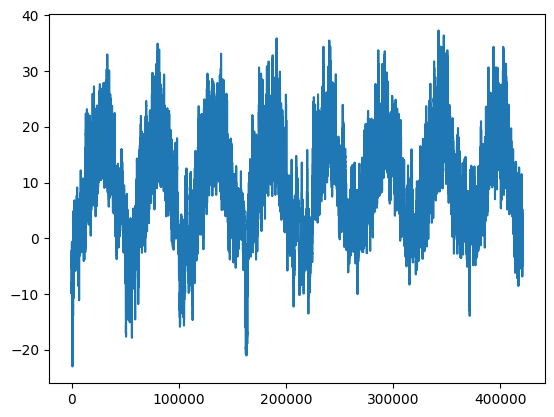

In [5]:
## Plotting the time series
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

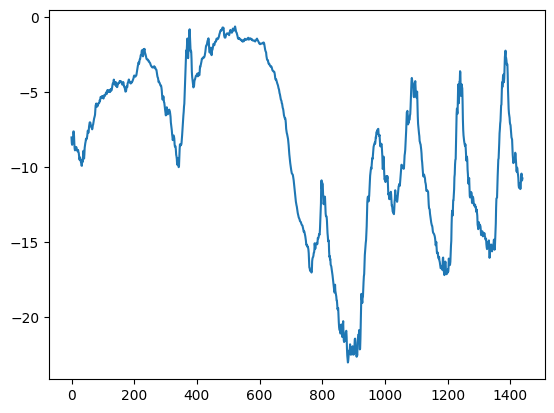

In [6]:
## Plotting the first 10 days
plt.plot(range(1440), temperature[:1440])

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
  data=int_sequence[:-3],
  targets=int_sequence[3:],
  sequence_length=3,
  batch_size=2,
)

for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
  raw_data[:-delay],
  targets=temperature[delay:],
  sampling_rate=sampling_rate,
  sequence_length=sequence_length,
  shuffle=True,
  batch_size=batch_size,
  start_index=0,
  end_index=num_train_samples)

In [11]:
val_dataset = keras.utils.timeseries_dataset_from_array(
  raw_data[:-delay],
  targets=temperature[delay:],
  sampling_rate=sampling_rate,
  sequence_length=sequence_length,
  shuffle=True,
  batch_size=batch_size,
  start_index=num_train_samples,
  end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
  raw_data[:-delay],
  targets=temperature[delay:],
  sampling_rate=sampling_rate,
  sequence_length=sequence_length,
  shuffle=True,
  batch_size=batch_size,
  start_index=num_train_samples + num_val_samples)

In [12]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


In [13]:
#Original LSTM Model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [ keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
save_best_only=True) ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,epochs=10,
  validation_data=val_dataset,
  callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 156s 186ms/step - loss: 49.3371 - mae: 5.2099 - val_loss: 9.6741 - val_mae: 2.4222
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: 15.3713 - mae: 3.0535 - val_loss: 9.3069 - val_mae: 2.3786
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 165ms/step - loss: 14.5874 - mae: 2.9677 - val_loss: 9.0825 - val_mae: 2.3436
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 169ms/step - loss: 14.0576 - mae: 2.9079 - val_loss: 9.0930 - val_mae: 2.3423
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: 13.7166 - mae: 2.8705 - val_loss: 9.0616 - val_mae: 2.3319
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 168ms/step - loss: 13.4174 - mae: 2.8406 - val_loss: 8.8150 - val_mae: 2.3009
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 170ms/step - loss: 12.9291 - mae: 2.7949 - val_loss: 9.2478 - val_mae: 2.3498
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 171ms/step - loss: 12.7332 - mae: 2.7715 - val_loss: 8.9017 - val_mae: 2.3045
Epoch 9/10
819/8

819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 80ms/step - loss: 9.2858 - mae: 2.3715
Training Loss: 9.294373512268066
Training MAE: 2.3719050884246826
Test Loss (Best Model): 10.064805030822754
Test MAE (Best Model): 2.4931676387786865


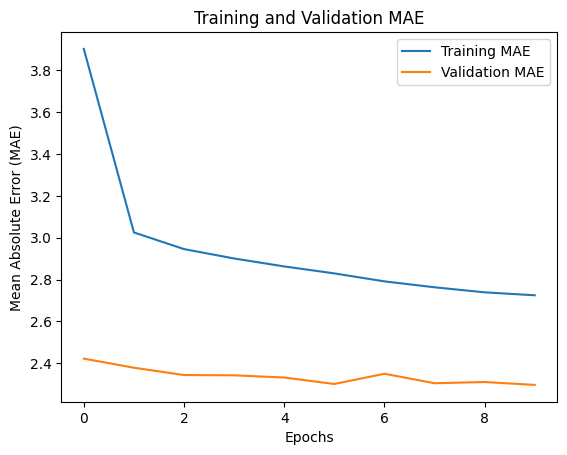

In [14]:
#Evaluating and Visualing Original LSTM Model
best_model = keras.models.load_model("jena_lstm_dropout.keras")

train_loss, train_mae = best_model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training MAE: {train_mae}")

test_loss, test_mae = best_model.evaluate(test_dataset, verbose=0)
print(f"Test Loss (Best Model): {test_loss}")
print(f"Test MAE (Best Model): {test_mae}")

training_mae = history.history['mae']
validation_mae = history.history['val_mae']

plt.plot(training_mae, label='Training MAE')
plt.plot(validation_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

In [15]:
#SimpleRNN
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [ keras.callbacks.ModelCheckpoint("jena_simpleRNN_dropout.keras",
save_best_only=True) ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,epochs=10,
  validation_data=val_dataset,
  callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 101ms/step - loss: 67.6192 - mae: 6.3877 - val_loss: 10.1021 - val_mae: 2.4489
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - loss: 16.7378 - mae: 3.1915 - val_loss: 9.5107 - val_mae: 2.3949
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 98ms/step - loss: 15.2594 - mae: 3.0335 - val_loss: 9.4701 - val_mae: 2.3933
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - loss: 14.8640 - mae: 2.9953 - val_loss: 9.3793 - val_mae: 2.3824
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - loss: 14.6176 - mae: 2.9677 - val_loss: 9.4617 - val_mae: 2.3929
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 103ms/step - loss: 14.3570 - mae: 2.9441 - val_loss: 9.3457 - val_mae: 2.3796
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 100ms/step - loss: 14.1904 - mae: 2.9293 - val_loss: 9.3349 - val_mae: 2.3784
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - loss: 13.9587 - mae: 2.9033 - val_loss: 9.3278 - val_mae: 2.3754
Epoch 9/10
819/819 ━━━

819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 10.8703 - mae: 2.5772
Training Loss: 10.90532112121582
Training MAE: 2.5803632736206055
Test Loss (Best Model): 10.73873519897461
Test MAE (Best Model): 2.533039093017578


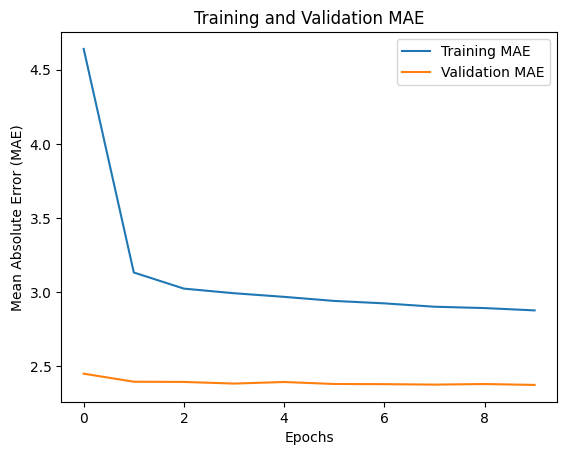

In [16]:
#Evaluating and Visualing SimpleRNN Model
best_model = keras.models.load_model("jena_simpleRNN_dropout.keras")

train_loss, train_mae = best_model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training MAE: {train_mae}")

test_loss, test_mae = best_model.evaluate(test_dataset, verbose=0)
print(f"Test Loss (Best Model): {test_loss}")
print(f"Test MAE (Best Model): {test_mae}")

training_mae = history.history['mae']
validation_mae = history.history['val_mae']

plt.plot(training_mae, label='Training MAE')
plt.plot(validation_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

In [17]:
#Original LSTM Model (8 units instead of 32)
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [ keras.callbacks.ModelCheckpoint("jena_lstm8_dropout.keras",
save_best_only=True) ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,epochs=10,
  validation_data=val_dataset,
  callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 118s 142ms/step - loss: 88.8443 - mae: 7.4780 - val_loss: 25.8051 - val_mae: 3.7552
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 121s 117ms/step - loss: 33.1424 - mae: 4.3292 - val_loss: 12.9347 - val_mae: 2.7361
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 120ms/step - loss: 26.0707 - mae: 3.8806 - val_loss: 11.1253 - val_mae: 2.5830
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 117ms/step - loss: 23.9388 - mae: 3.7209 - val_loss: 10.5737 - val_mae: 2.5340
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 118ms/step - loss: 22.6639 - mae: 3.6324 - val_loss: 10.1517 - val_mae: 2.4867
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 97s 118ms/step - loss: 21.5127 - mae: 3.5438 - val_loss: 9.9231 - val_mae: 2.4637
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 99s 121ms/step - loss: 20.8164 - mae: 3.4890 - val_loss: 9.8086 - val_mae: 2.4475
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 120ms/step - loss: 20.0646 - mae: 3.4305 - val_loss: 9.7897 - val_mae: 2.4449
Epoch 9/10
81

819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 11.1219 - mae: 2.6184
Training Loss: 11.131068229675293
Training MAE: 2.6170692443847656
Test Loss (Best Model): 10.98408031463623
Test MAE (Best Model): 2.5845823287963867


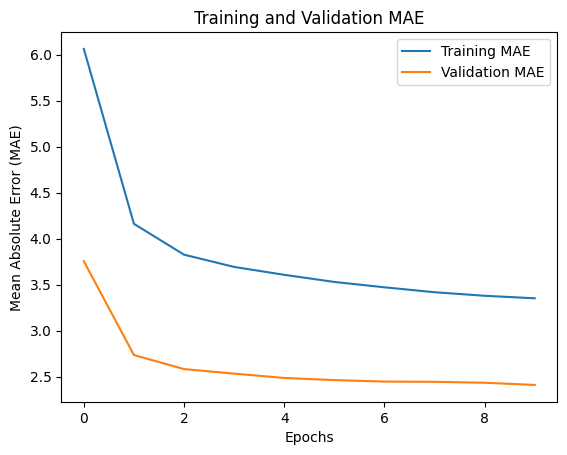

In [18]:
#Evaluating and Visualing LSTM8 Model
best_model = keras.models.load_model("jena_lstm8_dropout.keras")

train_loss, train_mae = best_model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training MAE: {train_mae}")

test_loss, test_mae = best_model.evaluate(test_dataset, verbose=0)
print(f"Test Loss (Best Model): {test_loss}")
print(f"Test MAE (Best Model): {test_mae}")

training_mae = history.history['mae']
validation_mae = history.history['val_mae']

plt.plot(training_mae, label='Training MAE')
plt.plot(validation_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

In [19]:
#Original LSTM Model (2 Layers)
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [ keras.callbacks.ModelCheckpoint("jena_lstm_2layer_dropout.keras",
save_best_only=True) ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,epochs=10,
  validation_data=val_dataset,
  callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 153s 183ms/step - loss: 48.1669 - mae: 5.1355 - val_loss: 9.5835 - val_mae: 2.4093
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 189s 168ms/step - loss: 15.4088 - mae: 3.0503 - val_loss: 9.2551 - val_mae: 2.3751
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 136s 165ms/step - loss: 14.4689 - mae: 2.9551 - val_loss: 9.1434 - val_mae: 2.3550
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 146s 170ms/step - loss: 14.0161 - mae: 2.9043 - val_loss: 9.0862 - val_mae: 2.3471
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 170ms/step - loss: 13.5829 - mae: 2.8591 - val_loss: 8.8980 - val_mae: 2.3246
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 137s 167ms/step - loss: 13.3238 - mae: 2.8337 - val_loss: 8.9765 - val_mae: 2.3259
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 170ms/step - loss: 12.9558 - mae: 2.7944 - val_loss: 8.8308 - val_mae: 2.3085
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 168ms/step - loss: 12.6430 - mae: 2.7584 - val_loss: 8.9026 - val_mae: 2.3134
Epoch 9/10
819/8

819/819 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - loss: 8.8666 - mae: 2.3198
Training Loss: 8.89011001586914
Training MAE: 2.322329521179199
Test Loss (Best Model): 9.778019905090332
Test MAE (Best Model): 2.462557792663574


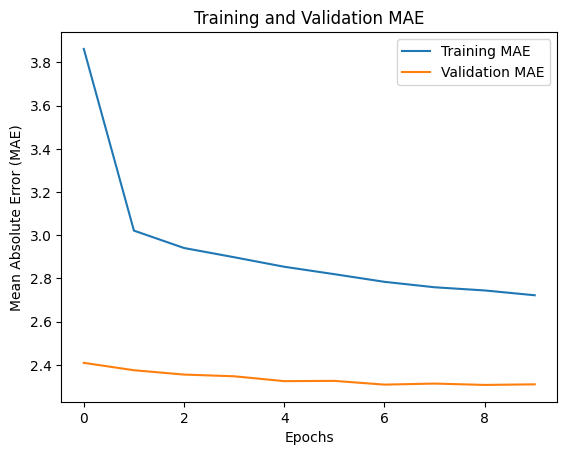

In [20]:
#Evaluating and Visualing LSTM Model (2 Layers)
best_model = keras.models.load_model("jena_lstm_2layer_dropout.keras")

train_loss, train_mae = best_model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training MAE: {train_mae}")

test_loss, test_mae = best_model.evaluate(test_dataset, verbose=0)
print(f"Test Loss (Best Model): {test_loss}")
print(f"Test MAE (Best Model): {test_mae}")

training_mae = history.history['mae']
validation_mae = history.history['val_mae']

plt.plot(training_mae, label='Training MAE')
plt.plot(validation_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

In [ ]:
'''Original LSTM:
Training Loss: 9.294373512268066
Training MAE: 2.3719050884246826
Test Loss (Best Model): 10.064805030822754
Test MAE (Best Model): 2.4931676387786865

  SimpleRNN:
Training Loss: 10.90532112121582
Training MAE: 2.5803632736206055
Test Loss (Best Model): 10.73873519897461
Test MAE (Best Model): 2.533039093017578

  LSTM 8 parameters:
Training Loss: 11.131068229675293
Training MAE: 2.6170692443847656
Test Loss (Best Model): 10.98408031463623
Test MAE (Best Model): 2.5845823287963867

  LSTM 2 layers:
Training Loss: 8.89011001586914
Training MAE: 2.322329521179199
Test Loss (Best Model): 9.778019905090332
Test MAE (Best Model): 2.462557792663574


As we can see from all of the graphs, the training MAE did worse at every epoch than the validation MAE. This is because we are using dropout on the training set, introducing noise.
All models did very similiar to one another.
The one that performed the best was LSTM 2 layer with a test MAE of 2.462557792663574
In 2nd place, the original LSTM model had a test MAE of 2.4931676387786865
Third was the SimpleRNN with a test MAE of 2.533039093017578
  - Note: This model was significantly faster to train than the LSTM and only marginally did worse than it.
Last, we have the LSTM model with 8 parameters with a test MAE of 2.5845823287963867

All models did very well. '''